In [1]:
# import Pkg; Pkg.add(Pkg.PackageSpec(url="https://github.com/JuliaComputing/JuliaAcademyData.jl"))
# using JuliaAcademyData; activate("Deep learning with Flux")

## Using `Flux.jl`

In [2]:
using Flux, Plots

In [3]:
?σ

"σ" can be typed by \sigma<tab>

search: σ logσ hardσ



```
σ(x) = 1 / (1 + exp(-x))
```

Classic [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function.


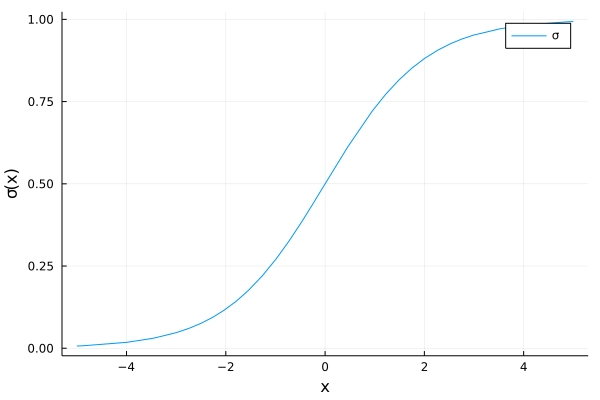

In [4]:
plot(σ, -5, 5, label="\\sigma", xlabel="x", ylabel="\\sigma\\(x\\)")

In [5]:
model = Dense(2, 1, σ)

Dense(2, 1, σ)      # 3 parameters

In [6]:
model.W

1×2 Matrix{Float32}:
 0.91425  0.60357

In [7]:
model.b

1-element Vector{Float32}:
 0.0

In [8]:
typeof(model.W)

Matrix{Float32} (alias for Array{Float32, 2})

In [9]:
x = rand(2)
model(x)

1-element Vector{Float64}:
 0.6852260312615592

In [10]:
σ.(model.W*x + model.b)

1-element Vector{Float64}:
 0.6852260312615592

In [11]:
methods(Flux.mse)

# 1 method for generic function "mse":
[1] mse(ŷ, y; agg) in Flux.Losses at /home/xteca/.julia/packages/Flux/Zz9RI/src/losses/functions.jl:45

In [12]:
using CSV, DataFrames

In [13]:
apples = CSV.read("data/apples.dat", normalizenames=true, DataFrame);
bananas = CSV.read("data/bananas.dat", normalizenames=true, DataFrame);

In [14]:
x_apples = hcat(apples.red, apples.green)';
x_bananas = hcat(bananas.red, bananas.green)';

In [15]:
x_apples

2×492 adjoint(::Matrix{Float64}) with eltype Float64:
 0.501466  0.434225  0.43412   0.432922  …  0.471226  0.52215   0.471621
 0.229304  0.128667  0.128334  0.127469     0.150144  0.199051  0.150672

In [16]:
typeof(x_apples)

LinearAlgebra.Adjoint{Float64, Matrix{Float64}}

In [17]:
xs = hcat(x_apples, x_bananas);
ys = hcat(fill(0, 1, size(x_apples)[2]), fill(1, 1, size(x_bananas)[2]))

1×982 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  1  1  1  1  1  1  1  1  1  1  1

In [18]:
@show size(xs);
@show size(ys);

size(xs) = (2, 982)
size(ys) = (1, 982)


In [19]:
model = Dense(2, 1, σ)

Dense(2, 1, σ)      # 3 parameters

In [20]:
loss(x, y) = Flux.mse(model(x), y)

loss (generic function with 1 method)

### Backpropagation

In [21]:
@show model.W;
@show model.b;

model.W = Float32[0.92595243 -0.21827346]
model.b = Float32[0.0]


In [22]:
grads = gradient(params(model)) do
    loss(xs, ys)
end

Grads(...)

In [23]:
@show grads[model.W];
@show grads[model.b];

grads[model.W] = [0.016573203239051516 -0.016367515881668022]
grads[model.b] = Float32[0.048937287]


In [24]:
using Flux.Optimise: ADAM, update!

In [25]:
η = 0.1
for p in params(model)
    update!(p, -η * grads[p])
end

In [26]:
@show model.W;
@show model.b;

model.W = Float32[0.92760974 -0.21991022]
model.b = Float32[0.0048937285]


In [27]:
@show grads[model.W];
@show grads[model.b];

grads[model.W] = [0.016573203239051516 -0.016367515881668022]
grads[model.b] = Float32[0.048937287]


### Train

In [28]:
?ADAM

search: ADAM ADAMW AdaMax RADAM OADAM NADAM AdaptiveMaxPool AdaptiveMeanPool



```
ADAM(η = 0.001, β::Tuple = (0.9, 0.999))
```

[ADAM](https://arxiv.org/abs/1412.6980) optimiser.

# Parameters

  * Learning rate (`η`): Amount by which gradients are discounted before updating                      the weights.
  * Decay of momentums (`β::Tuple`): Exponential decay for the first (β1) and the                                  second (β2) momentum estimate.

# Examples

```julia
opt = ADAM()

opt = ADAM(0.001, (0.9, 0.8))
```


In [29]:
?Flux.train!

```
train!(loss, params, data, opt; cb)
```

For each datapoint `d` in `data`, compute the gradient of  `loss` with respect to `params` through backpropagation and call the optimizer `opt`.

If `d` is a tuple of arguments to `loss` call `loss(d...)`, else call `loss(d)`.

A callback is given with the keyword argument `cb`. For example, this will print "training" every 10 seconds (using [`Flux.throttle`](@ref)):     train!(loss, params, data, opt, cb = throttle(() -> println("training"), 10))

The callback can call [`Flux.stop`](@ref) to interrupt the training loop.

Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.


In [30]:
#using Pipe: @pipe

η = 0.1
epochs = 500
train_loss = Vector{Float32}(undef, epochs)

model = Dense(2, 1, σ)
L(x, y) = Flux.mse(model(x), y)
opt = ADAM(η)

for i=1:epochs
    Flux.train!(L, params(model), [(xs, ys)], opt)
    Loss = L(xs, ys)
    train_loss[i] = Loss
end

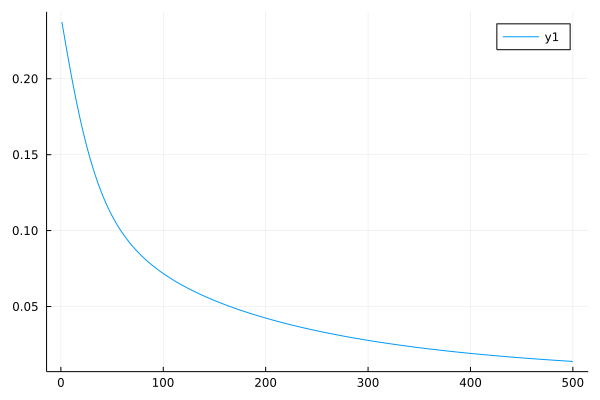

In [31]:
plot(train_loss)

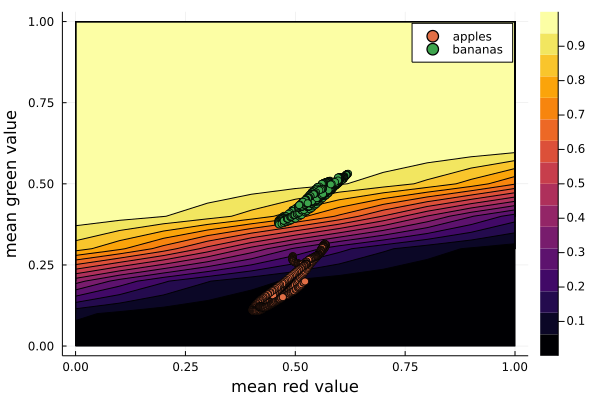

In [32]:
contour(0:.1:1, 0:.1:1, (x, y) -> model([x,y])[1], fill=true)
scatter!(x_apples[1,:], x_apples[2,:], label="apples")
scatter!(x_bananas[1,:], x_bananas[2,:], label="bananas")
xlabel!("mean red value")
ylabel!("mean green value")